# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

In [16]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)



In [20]:
CONTEXT_WINDOW = 100  # Number of characters before/after for context
INAUGURATION_DATE = datetime(2025, 1, 20) 

In [29]:
# Claude Composer don't touch this cell!

SEARCH_PHRASES = {
    'Immigration': r'\b(illegal\s+immigra(nt|nts|nt\'s|nts\')|immigration)\b',
    'America First': r'\b(america\s+first)\b',
    'America': r'\b(america|america\'s)\b', 
    'Border': r'\b(border|borders|border\'s|borders\')\b',
    'DOGE': r'\b(doge|doge\'s|department\s+of\s+government\s+efficiency)\b',
    'AI': r'\b(ai|ai\'s|artificial\s+intelligence|artificial\s+intelligence\'s)\b',
    'Ceasefire': r'\b(ceasefire|ceasefires|ceasefire\'s|ceasefires\')\b',
    'Middle Class': r'\b(middle\s+class|middle\s+class\'s|middle\s+classes|middle\s+classes\')\b',
    'God': r'\b(god|god\'s|gods|gods\')\b',
    'Elon': r'\b(elon|elon\'s|elon\s+musk|elon\s+musk\'s)\b',
    'Drill Baby Drill': r'\bdrill\s+baby\s+drill\b',
    'Biden': r'\b(biden|biden\'s)\b',
    'Make America Healthy Again': r'\bmake\s+america\s+healthy\s+again\b',
    'LA': r'\b(la|la\'s|los\s+angeles|los\s+angeles\')\b',
    'January 6': r'\b(january\s+6(th)?|january\s+sixth)\b',
    'TikTok': r'\b(tiktok|tiktok\'s)\b',
    'Crypto': r'\b(crypto|crypto\'s|cryptos|bitcoin|bitcoin\'s)\b',
    'MAGA': r'\b(maga|maga\'s|make\s+america\s+great\s+again)\b',
    'Trans': r'\b(trans|trans\')\b',
    'Kamala': r'\b(kamala|kamala\'s)\b',
    'Rigged': r'\b(rig(ged)?)\b',
    'Mandate': r'\b(mandate|mandates|mandate\'s|mandates\')\b',
    'Carnage': r'\b(carnage|carnage\'s)\b'
}

In [21]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        
        if category in ['speech', 'sotu']:
            for file in files:
                if file.endswith('.txt'):
                    filepath = os.path.join(root, file)
                    try:
                        date = get_date_from_filename(file)
                        text = read_transcript(filepath)
                        counts = count_phrases(text)
                        
                        results.append({
                            'date': date,
                            'file': file,
                            'category': category,
                            'text_length': len(text.split()),
                            'text': text,  # Store full text for context analysis
                            **counts
                        })
                    except Exception as e:
                        print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)

In [22]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Split into categories
df_pre_inaug = df[(df['category'] == 'speech') & (df['date'] < INAUGURATION_DATE)]
df_post_inaug = df[(df['category'] == 'speech') & (df['date'] >= INAUGURATION_DATE)]
df_sotu = df[df['category'] == 'sotu']

# Print dataset statistics
print("Dataset Statistics:")
print(f"Pre-inauguration speeches: {len(df_pre_inaug)}")
print(f"Post-inauguration speeches: {len(df_post_inaug)}")
print(f"SOTU addresses: {len(df_sotu)}")

print("\nWord Count Statistics:")
print(f"Pre-inauguration average length: {df_pre_inaug['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_post_inaug['text_length'].mean():.0f} words")
print(f"SOTU average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print(f"Pre-inauguration: {df_pre_inaug['date'].min().strftime('%Y-%m-%d')} to {df_pre_inaug['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_post_inaug['date'].min().strftime('%Y-%m-%d')} to {df_post_inaug['date'].max().strftime('%Y-%m-%d')}")
print(f"SOTU addresses: {df_sotu['date'].min().strftime('%Y-%m-%d')} to {df_sotu['date'].max().strftime('%Y-%m-%d')}")

Categories found in directory:
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:
Pre-inauguration speeches: 149
Post-inauguration speeches: 8
SOTU addresses: 4

Word Count Statistics:
Pre-inauguration average length: 11991 words
Post-inauguration average length: 5994 words
SOTU average length: 5421 words

Date Ranges:
Pre-inauguration: 2023-09-29 to 2024-12-22
Post-inauguration: 2025-01-20 to 2025-02-07
SOTU addresses: 2017-02-28 to 2020-02-04


## Phrase Frequency Over Time

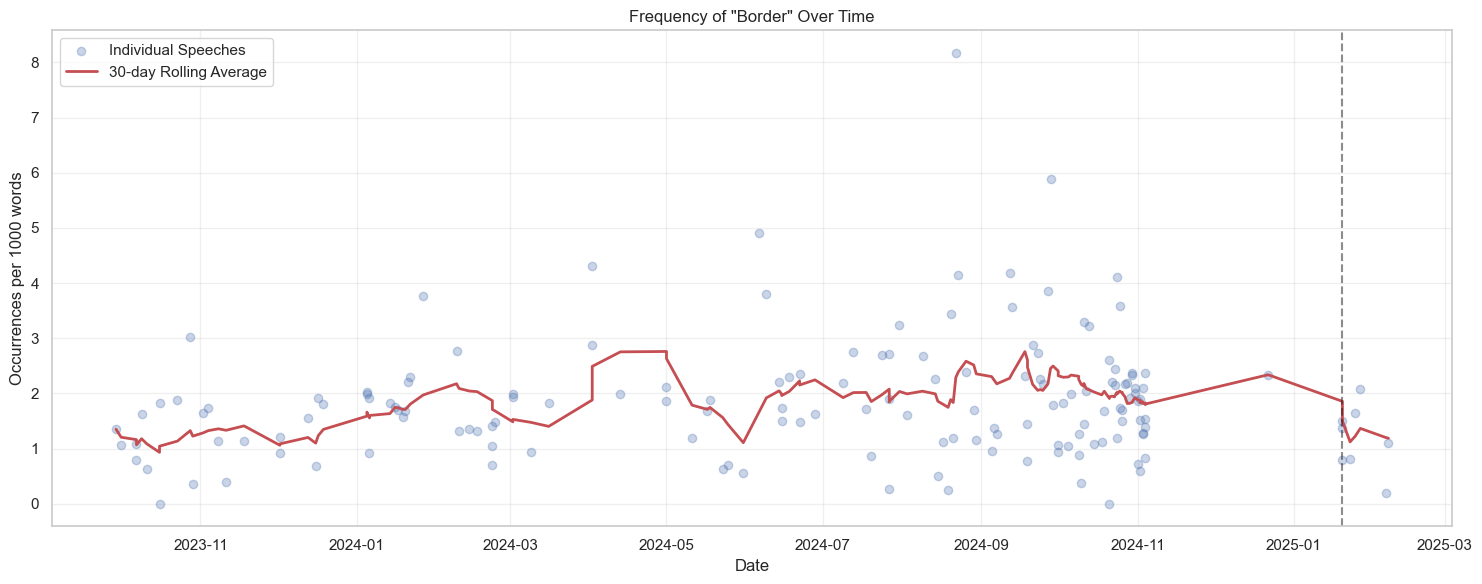

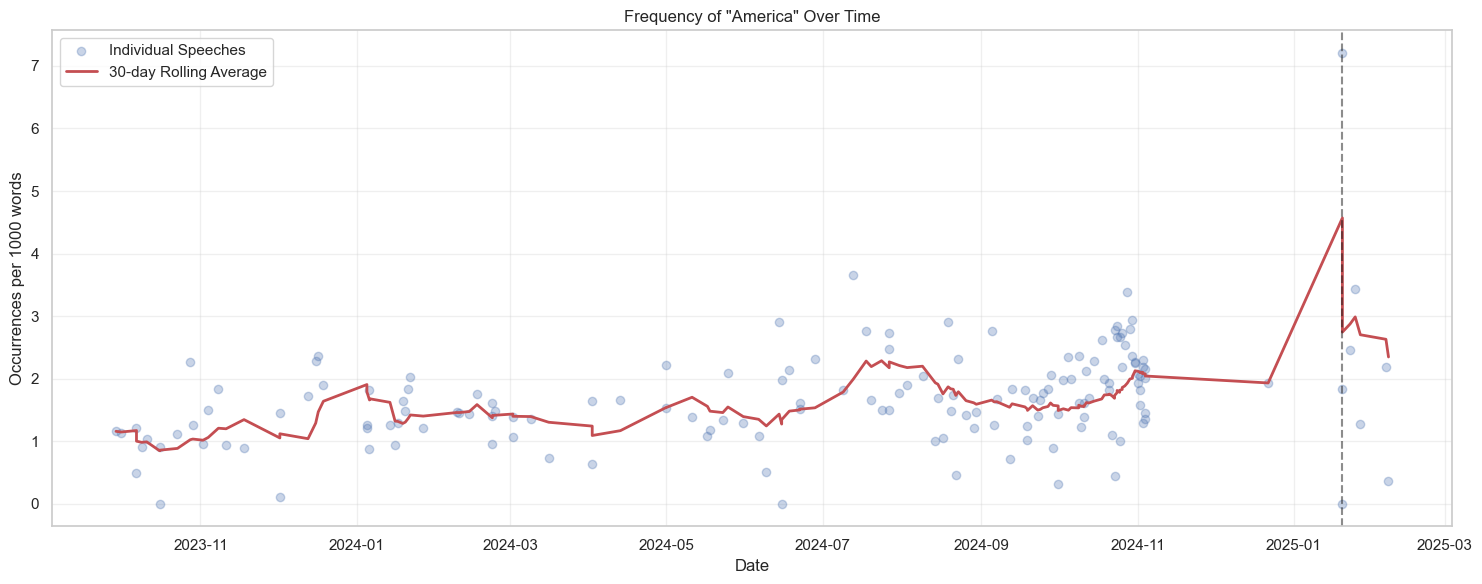

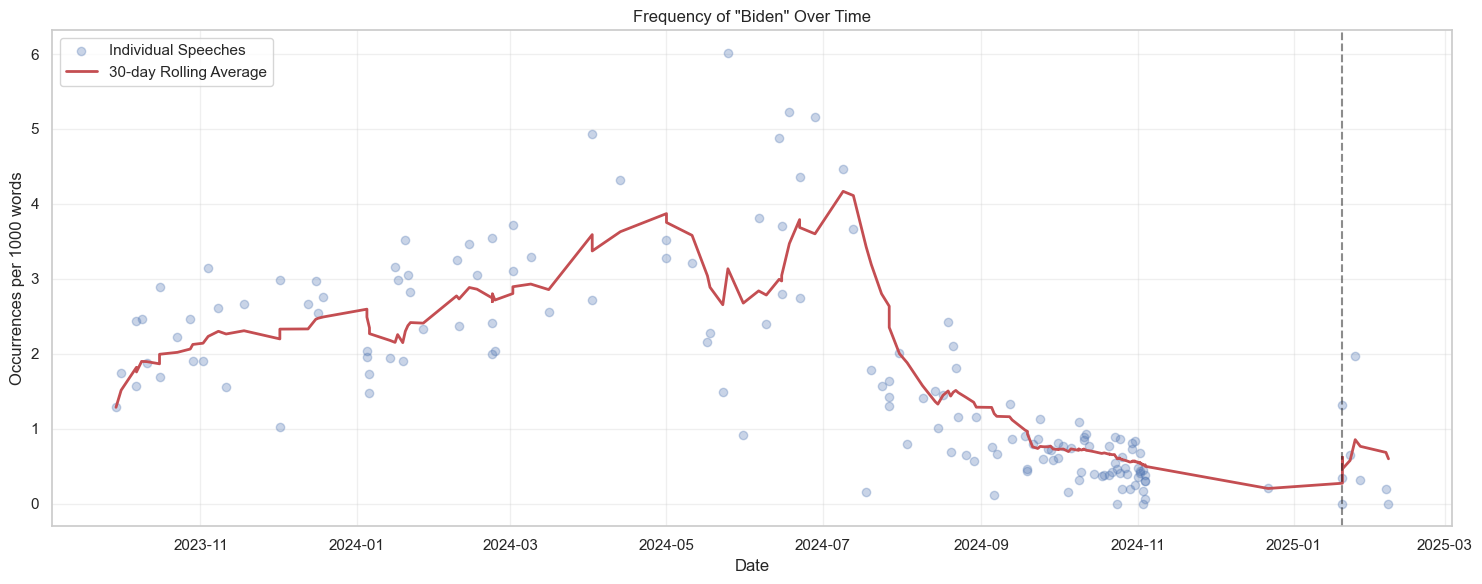

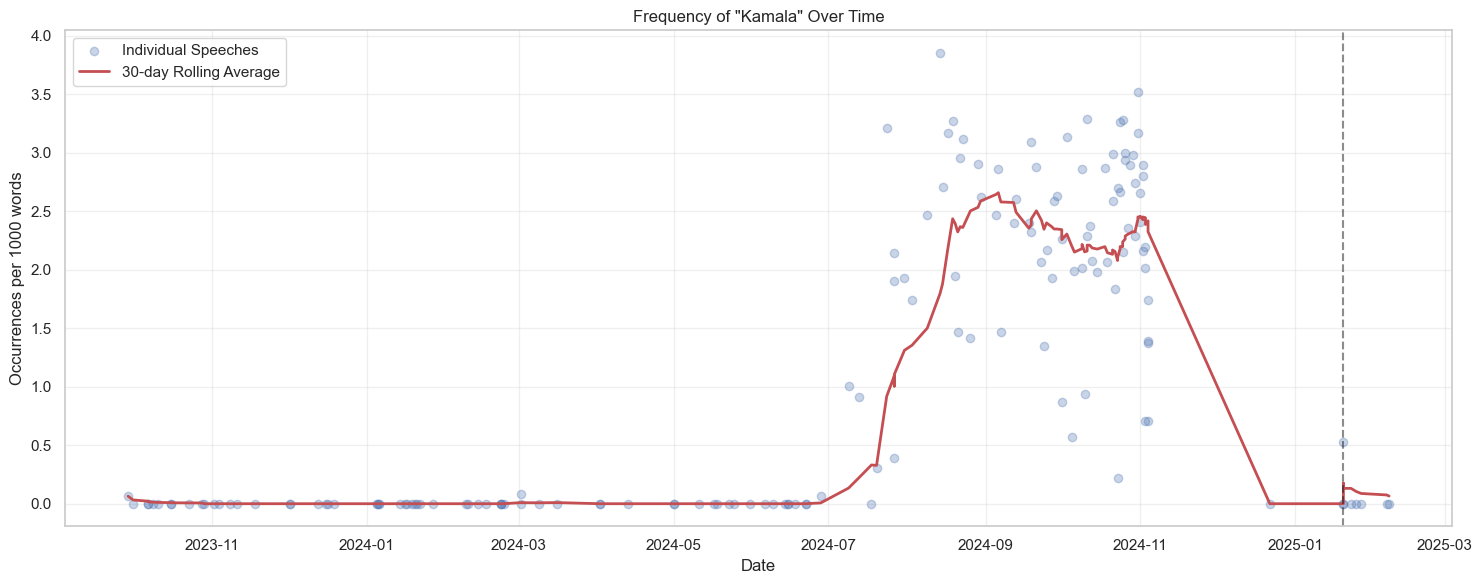

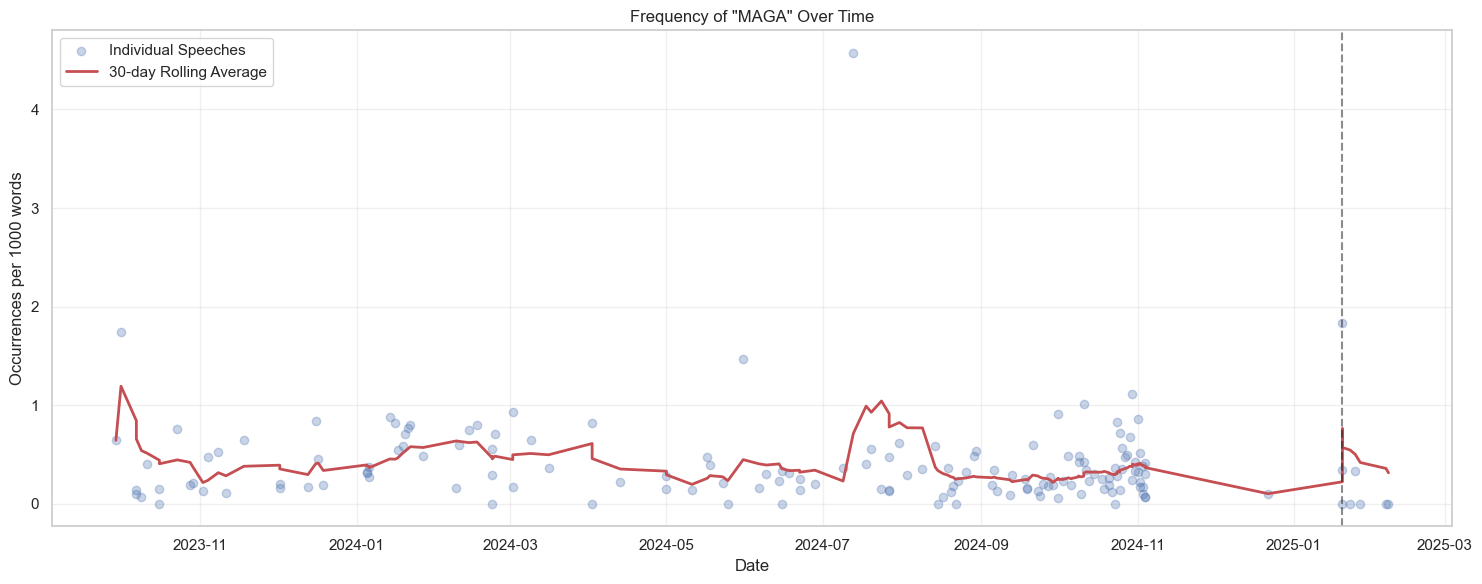

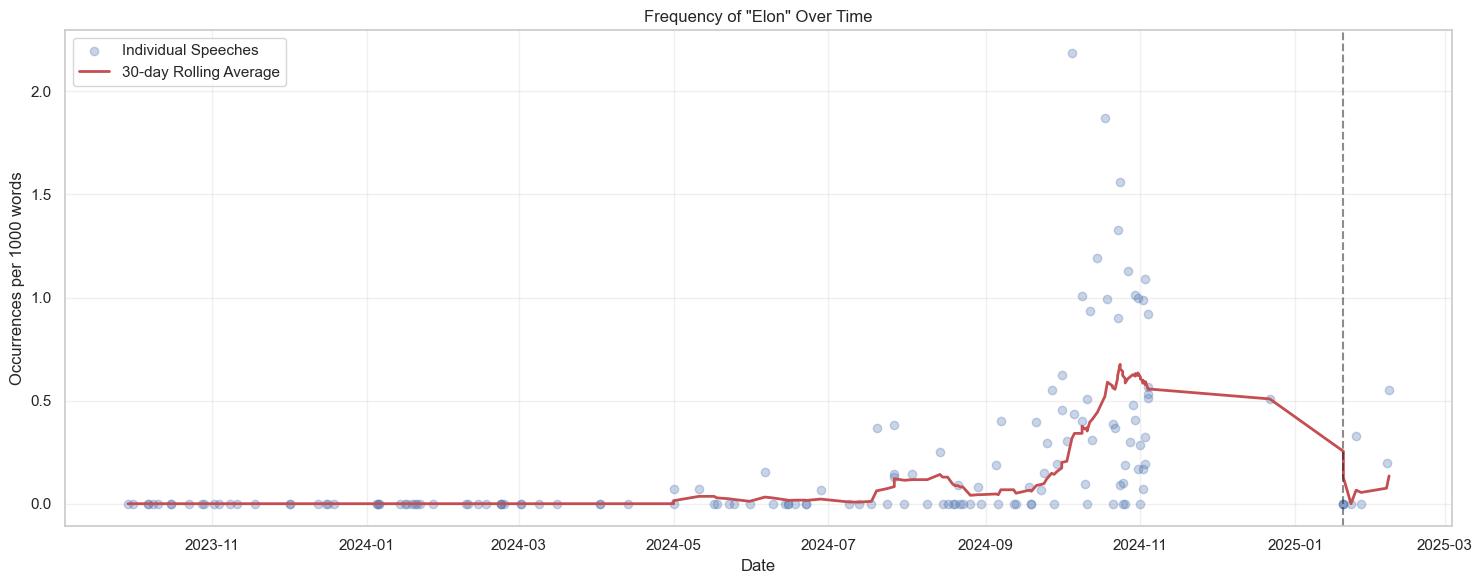

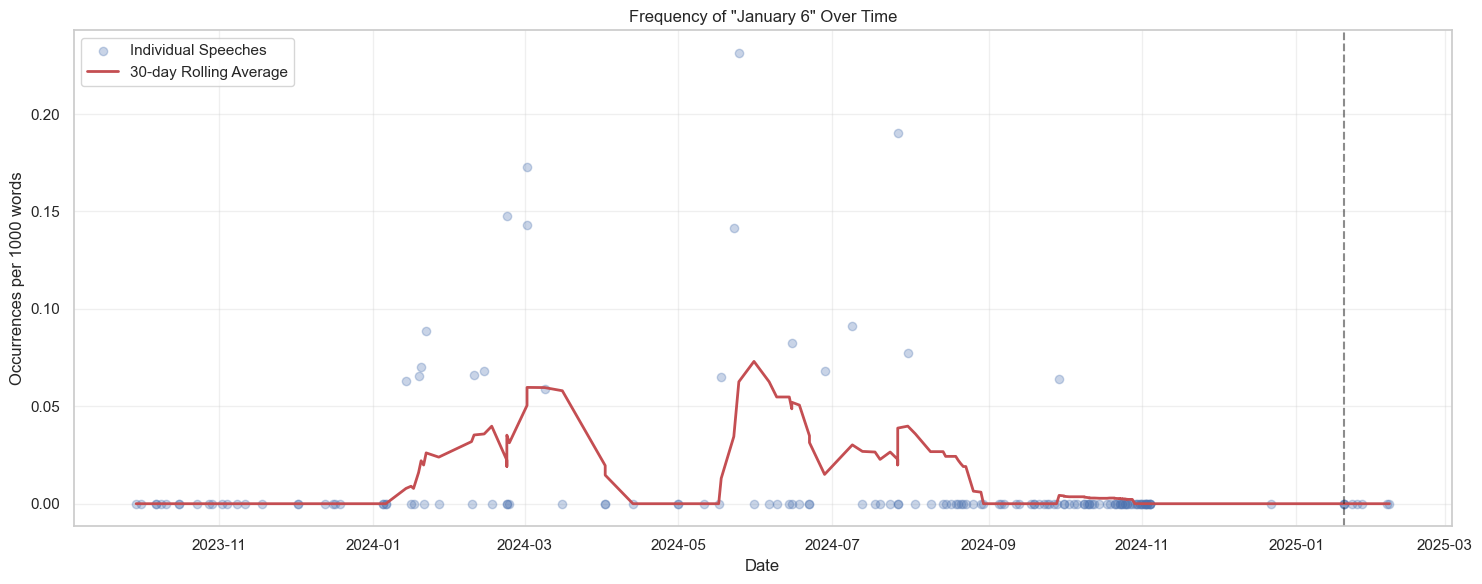

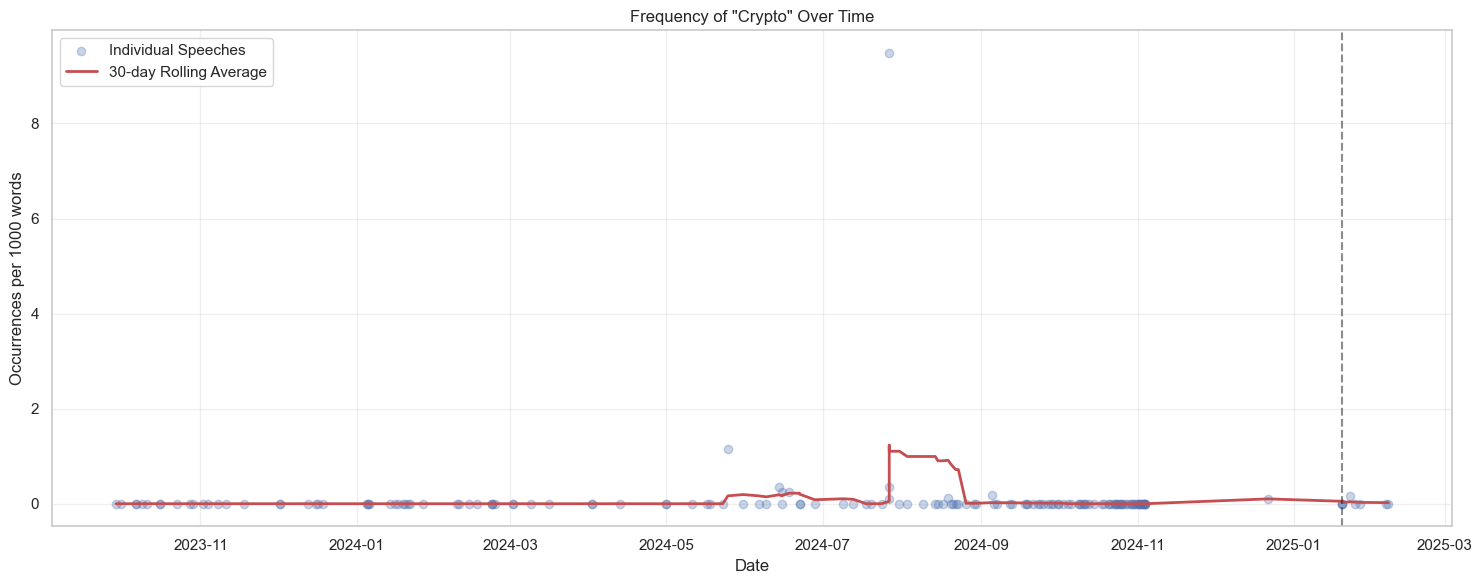

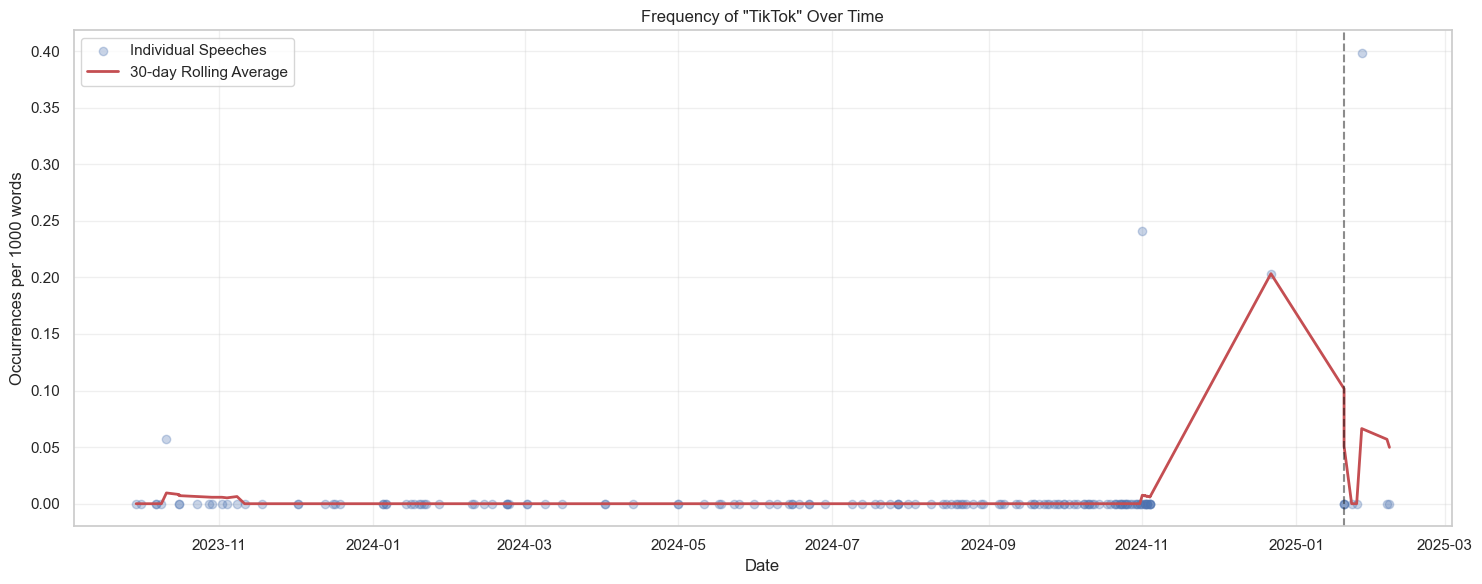

In [25]:
def plot_phrase_frequency_over_time(df, phrase, window=30):
    """Plot the frequency of a phrase over time with a rolling average"""
    # Calculate frequency per 1000 words for each speech
    df = df.copy()
    df[f'{phrase}_freq'] = (df[phrase] / df['text_length']) * 1000
    
    # Calculate rolling average
    freq_series = df.set_index('date')[f'{phrase}_freq']
    rolling_avg = freq_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.scatter(freq_series.index, freq_series.values, alpha=0.3, label='Individual Speeches')
    plt.plot(rolling_avg.index, rolling_avg.values, 'r-', linewidth=2, label=f'{window}-day Rolling Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    plt.tight_layout()
    plt.show()

# Plot time series for top 5 most frequent phrases
# Get top 5 most frequent phrases plus additional phrases of interest
base_phrases = df.drop(['date', 'file', 'category', 'text_length', 'text'], axis=1).sum().nlargest(5).index
additional_phrases = ['Elon', 'January 6', 'Crypto', 'TikTok']
top_phrases = pd.Index(list(base_phrases) + additional_phrases)

for phrase in top_phrases:
    plot_phrase_frequency_over_time(df[df['category'] == 'speech'], phrase)

## SOTU 2025 Predictions

In [27]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with confidence intervals using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate confidence intervals
        sigma = np.sqrt(expected)  # Standard deviation for Poisson
        
        # Calculate probability of at least one occurrence using Poisson
        prob_at_least_one = 1 - np.exp(-expected)  # P(X >= 1) = 1 - P(X = 0)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Lower 1σ': max(0, expected - sigma),
            'Upper 1σ': expected + sigma,
            'Lower 2σ': max(0, expected - 2*sigma),
            'Upper 2σ': expected + 2*sigma,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(Occurs)': prob_at_least_one
        })
    
    return pd.DataFrame(predictions)

# Use SOTU average length for predictions
avg_sotu_length = df_sotu['text_length'].mean()

# Calculate predictions from all sources
predictions_pre_inaug = calculate_poisson_predictions(df_pre_inaug, avg_sotu_length)
predictions_post_inaug = calculate_poisson_predictions(df_post_inaug, avg_sotu_length)
predictions_sotu = calculate_poisson_predictions(df_sotu, avg_sotu_length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['68% CI'] = formatted.apply(lambda x: f"({x['Lower 1σ']:.1f} - {x['Upper 1σ']:.1f})", axis=1)
    formatted['95% CI'] = formatted.apply(lambda x: f"({x['Lower 2σ']:.1f} - {x['Upper 2σ']:.1f})", axis=1)
    formatted['P(Occurs)'] = formatted['P(Occurs)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected', '68% CI', '95% CI', 'P(Occurs)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on pre-inauguration speeches:")
display(format_prediction_table(predictions_pre_inaug, 'pre-inauguration'))

print("\nPredictions based on post-inauguration speeches:")
display(format_prediction_table(predictions_post_inaug, 'post-inauguration'))

print("\nPredictions based on previous SOTU addresses:")
display(format_prediction_table(predictions_sotu, 'sotu'))

Predictions based on pre-inauguration speeches:


,Phrase,Expected,68% CI,95% CI,P(Occurs),Historical Rate,Total Historical
3,Border,9.82,(6.7 - 13.0),(3.5 - 16.1),100.0%,1.81,3237
11,Biden,9.17,(6.1 - 12.2),(3.1 - 15.2),100.0%,1.69,3021
2,America,8.76,(5.8 - 11.7),(2.8 - 14.7),100.0%,1.62,2886
19,Kamala,6.24,(3.7 - 8.7),(1.2 - 11.2),100.0%,1.15,2057
17,MAGA,2.02,(0.6 - 3.4),(0.0 - 4.9),87.0%,0.37,665
8,God,1.74,(0.4 - 3.0),(0.0 - 4.4),82.0%,0.32,572
20,Rigged,1.66,(0.4 - 2.9),(0.0 - 4.2),81.0%,0.31,546
9,Elon,1.07,(0.0 - 2.1),(0.0 - 3.1),66.0%,0.20,354
21,Mandate,0.88,(0.0 - 1.8),(0.0 - 2.8),59.0%,0.16,290
0,Immigration,0.63,(0.0 - 1.4),(0.0 - 2.2),46.0%,0.12,206



Predictions based on post-inauguration speeches:


,Phrase,Expected,68% CI,95% CI,P(Occurs),Historical Rate,Total Historical
2,America,10.51,(7.3 - 13.8),(4.0 - 17.0),100.0%,1.94,93
3,Border,7.24,(4.5 - 9.9),(1.9 - 12.6),100.0%,1.33,64
8,God,3.62,(1.7 - 5.5),(0.0 - 7.4),97.0%,0.67,32
11,Biden,3.05,(1.3 - 4.8),(0.0 - 6.5),95.0%,0.56,27
20,Rigged,1.47,(0.3 - 2.7),(0.0 - 3.9),77.0%,0.27,13
21,Mandate,1.13,(0.1 - 2.2),(0.0 - 3.3),68.0%,0.21,10
17,MAGA,1.13,(0.1 - 2.2),(0.0 - 3.3),68.0%,0.21,10
5,AI,1.02,(0.0 - 2.0),(0.0 - 3.0),64.0%,0.19,9
9,Elon,0.68,(0.0 - 1.5),(0.0 - 2.3),49.0%,0.13,6
1,America First,0.57,(0.0 - 1.3),(0.0 - 2.1),43.0%,0.10,5



Predictions based on previous SOTU addresses:


,Phrase,Expected,68% CI,95% CI,P(Occurs),Historical Rate,Total Historical
2,America,30.25,(24.8 - 35.8),(19.2 - 41.2),100.0%,5.58,121
3,Border,8.50,(5.6 - 11.4),(2.7 - 14.3),100.0%,1.57,34
0,Immigration,7.00,(4.3 - 9.7),(1.7 - 12.3),100.0%,1.29,28
8,God,5.50,(3.1 - 7.8),(0.8 - 10.2),100.0%,1.01,22
7,Middle Class,1.50,(0.3 - 2.7),(0.0 - 4.0),78.0%,0.28,6
21,Mandate,1.00,(0.0 - 2.0),(0.0 - 3.0),63.0%,0.18,4
1,America First,0.75,(0.0 - 1.6),(0.0 - 2.5),53.0%,0.14,3
17,MAGA,0.50,(0.0 - 1.2),(0.0 - 1.9),39.0%,0.09,2
20,Rigged,0.25,(0.0 - 0.8),(0.0 - 1.2),22.0%,0.05,1
18,Trans,0.25,(0.0 - 0.8),(0.0 - 1.2),22.0%,0.05,1


## Recent Usage Context

In [28]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Immigration' ===

Date: 2025-02-07 (speech)
Context: ... just leave them alone."

Now, there are people that are illegally in there 'cause we have a lot of illegal immigrants that have found their way in, and we just can't do that. We just can't do it. But, uh, just let's s...

Date: 2025-02-06 (speech)
Context: ...e been over, and you would have somebody else speaking today. But got very lucky. It was a chart on immigration came down and I looked to my right, quickly, I looked to my right, I said drop that chart.

Boom. A...

Date: 2025-01-27 (speech)
Context: ...g. And we did a great job. We had the lowest -- the week I left office, we had the lowest number of illegal immigrants coming into our country that we ever had.

Simultaneously, we must make a record investment in Inte...

Date: 2025-01-23 (speech)
Context: ...se each and every one of these radical left policies that created this calamity, in particular with immigration, crime and inflation. On day one, 